In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import ipywidgets as widgets
from ipywidgets import interact

In [7]:
data = pd.read_csv("../Merging/Merged_Data.csv")
data.head(5)

,period,plantCode,plantName,fuel2002,fuelTypeDescription,state,stateDescription,primeMover,total-consumption,total-consumption-units,...,SLP,STP,VISIB,WDSP,MXSPD,GUST,MAX,MIN,PRCP,SNDP
0,2023-08-01,63259,Delta Energy Park,NG,Natural Gas,MI,Michigan,ALL,922648.0,MMBtu per Mcf,...,1014.561290,983.287097,8.909677,5.854839,12.848387,400.861290,81.670968,58.432258,0.138065,999.900000
1,2023-03-01,63259,Delta Energy Park,NG,Natural Gas,MI,Michigan,ALL,592926.0,MMBtu per Mcf,...,1017.906452,952.787097,8.435484,8.370968,15.396774,213.812903,46.774194,27.229032,0.097742,710.458065
2,2022-04-01,63259,Delta Energy Park,NG,Natural Gas,MI,Michigan,ALL,909054.0,MMBtu per Mcf,...,1015.526667,983.276667,9.073333,9.273333,16.643333,123.983333,57.620000,35.900000,0.130333,999.900000
3,2023-10-01,63259,Delta Energy Park,NG,Natural Gas,MI,Michigan,ALL,547826.0,MMBtu per Mcf,...,1015.554839,983.629032,9.222581,6.670968,12.351613,369.432258,63.596774,43.464516,0.153871,999.900000
4,2022-08-01,63259,Delta Energy Park,NG,Natural Gas,MI,Michigan,ALL,1004884.0,MMBtu per Mcf,...,1016.296774,985.109677,9.448387,5.664516,12.803226,433.454839,84.222581,60.877419,0.201290,999.900000


In [8]:

data['period'] = pd.to_datetime(data['period'])
data.sort_values(by='period', inplace=True)
plant_codes = data['plantCode'].unique()
data = data[data['period'] >= '2020-01-01']

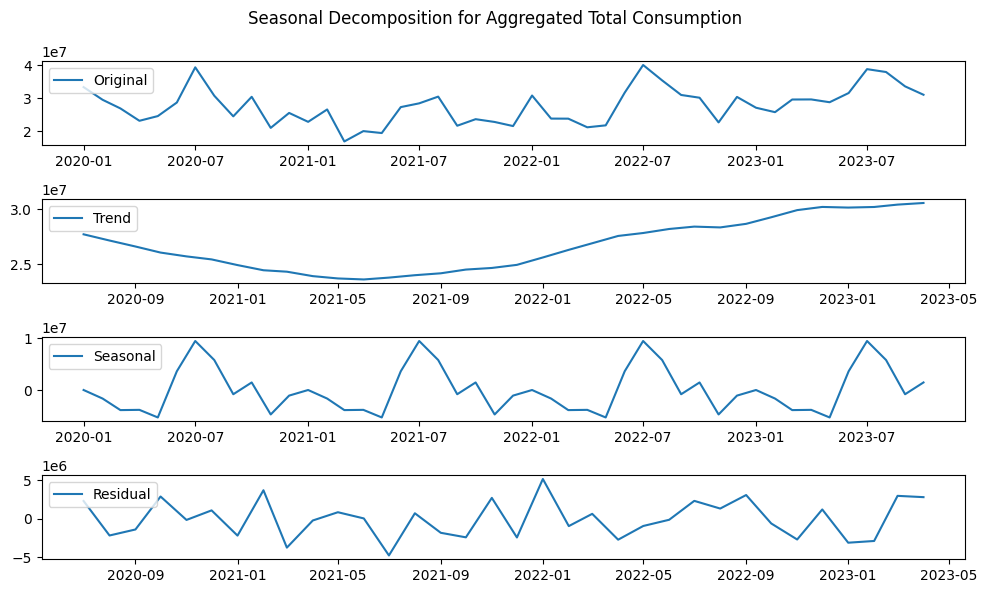

In [4]:
data['period'] = pd.to_datetime(data['period'])


aggregated_data = data.groupby('period')['total-consumption'].sum().reset_index()
aggregated_data.set_index('period', inplace=True)
result = seasonal_decompose(aggregated_data['total-consumption'], model='additive', period=12)


trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the decomposed components for aggregated total consumption
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(aggregated_data['total-consumption'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.suptitle("Seasonal Decomposition for Aggregated Total Consumption")
plt.tight_layout()
plt.show()

Not enough data for plant 1728. Skipping...
Not enough data for plant 1730. Skipping...
Not enough data for plant 1734. Skipping...
Not enough data for plant 1772. Skipping...
Not enough data for plant 1827. Skipping...
Not enough data for plant 1829. Skipping...
Not enough data for plant 1844. Skipping...
Not enough data for plant 1851. Skipping...
Not enough data for plant 1852. Skipping...
Not enough data for plant 1853. Skipping...
Not enough data for plant 1855. Skipping...
Not enough data for plant 1867. Skipping...
Not enough data for plant 1873. Skipping...
Not enough data for plant 1875. Skipping...
Not enough data for plant 1877. Skipping...
Not enough data for plant 1880. Skipping...
Not enough data for plant 1881. Skipping...
Not enough data for plant 7268. Skipping...
Not enough data for plant 7398. Skipping...
Not enough data for plant 7399. Skipping...
Not enough data for plant 7497. Skipping...
Not enough data for plant 7806. Skipping...
Not enough data for plant 7932. 

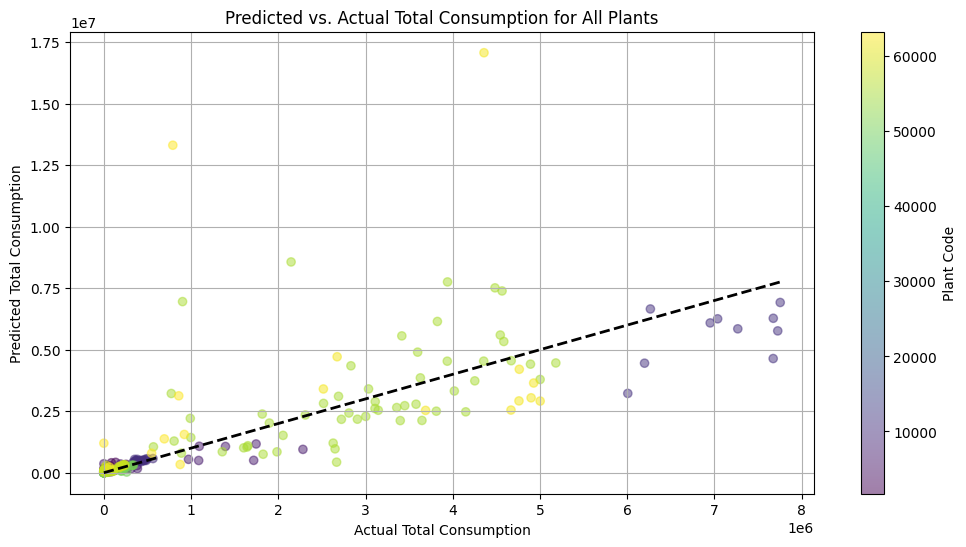

In [5]:

# Group data by plant code
grouped_data = data.groupby('plantCode')

# Lists to store actual and predicted total consumption
actual_consumption_all = []
predicted_consumption_all = []
plant_colors = []  # List to store colors for each plant

# Iterate over groups (plants)
for plant_code, plant_data in grouped_data:
    # Check if there is sufficient data for training and testing
    if len(plant_data) < 2:
        print(f"Not enough data for plant {plant_code}. Skipping...")
        continue
    
    # Exclude negative consumption values
    plant_data = plant_data[plant_data['total-consumption'] >= 0]
    
    # Extract features and target variable
    X = plant_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
    y = plant_data['total-consumption']
    
    # Define the time periods for training and testing
    start_train = '2020-01-01'
    end_train = '2022-12-31'
    start_test = '2023-01-01'
    end_test = '2023-12-31'
    
    # Filter the data for training and testing
    train_data = plant_data[(plant_data['period'] >= start_train) & (plant_data['period'] <= end_train)]
    test_data = plant_data[(plant_data['period'] >= start_test) & (plant_data['period'] <= end_test)]
    
    # Check if there is sufficient data for training and testing
    if len(train_data) < 2 or len(test_data) < 2:
        print(f"Not enough data for plant {plant_code}. Skipping...")
        continue
    
    # Extract features and target variable for training
    X_train = train_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
    y_train = train_data['total-consumption']
    
    # Extract features and target variable for testing
    X_test = test_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
    y_test = test_data['total-consumption']
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Append actual and predicted total consumption
    actual_consumption_all.extend(y_test)
    predicted_consumption_all.extend(y_pred)
    plant_colors.extend([plant_code] * len(y_pred))  # Assigning a color for each plant

# Remove negative values from the combined data
actual_consumption_all = np.array(actual_consumption_all)
predicted_consumption_all = np.array(predicted_consumption_all)
plant_colors = np.array(plant_colors)
mask = (actual_consumption_all >= 0) & (predicted_consumption_all >= 0)
actual_consumption_all = actual_consumption_all[mask]
predicted_consumption_all = predicted_consumption_all[mask]
plant_colors = plant_colors[mask]

# Evaluate the model for all plants combined
mse_all = mean_squared_error(actual_consumption_all, predicted_consumption_all)
r2_all = r2_score(actual_consumption_all, predicted_consumption_all)

print('Overall evaluation:')
print(f'Mean Squared Error: {mse_all}')
print(f'R-squared: {r2_all}')

# Plotting the predicted vs. actual total consumption for all plants
plt.figure(figsize=(12, 6))
plt.scatter(actual_consumption_all, predicted_consumption_all, c=plant_colors, cmap='viridis', alpha=0.5)
plt.plot([min(actual_consumption_all), max(actual_consumption_all)], [min(actual_consumption_all), max(actual_consumption_all)], 'k--', lw=2)  # Plotting the diagonal line
plt.title('Predicted vs. Actual Total Consumption for All Plants')
plt.xlabel('Actual Total Consumption')
plt.ylabel('Predicted Total Consumption')
plt.grid(True)
plt.colorbar(label='Plant Code')
plt.show()

Not enough data for plant 1728. Skipping...
Not enough data for plant 1730. Skipping...
Not enough data for plant 1734. Skipping...
Not enough data for plant 1772. Skipping...
Not enough data for plant 1827. Skipping...
Not enough data for plant 1829. Skipping...
Not enough data for plant 1844. Skipping...
Not enough data for plant 1851. Skipping...
Not enough data for plant 1852. Skipping...
Not enough data for plant 1853. Skipping...
Not enough data for plant 1855. Skipping...
Not enough data for plant 1867. Skipping...
Not enough data for plant 1873. Skipping...
Not enough data for plant 1875. Skipping...
Not enough data for plant 1877. Skipping...
Not enough data for plant 1880. Skipping...
Not enough data for plant 1881. Skipping...
Not enough data for plant 7268. Skipping...
Not enough data for plant 7398. Skipping...
Not enough data for plant 7399. Skipping...
Not enough data for plant 7497. Skipping...
Not enough data for plant 7806. Skipping...
Not enough data for plant 7932. 

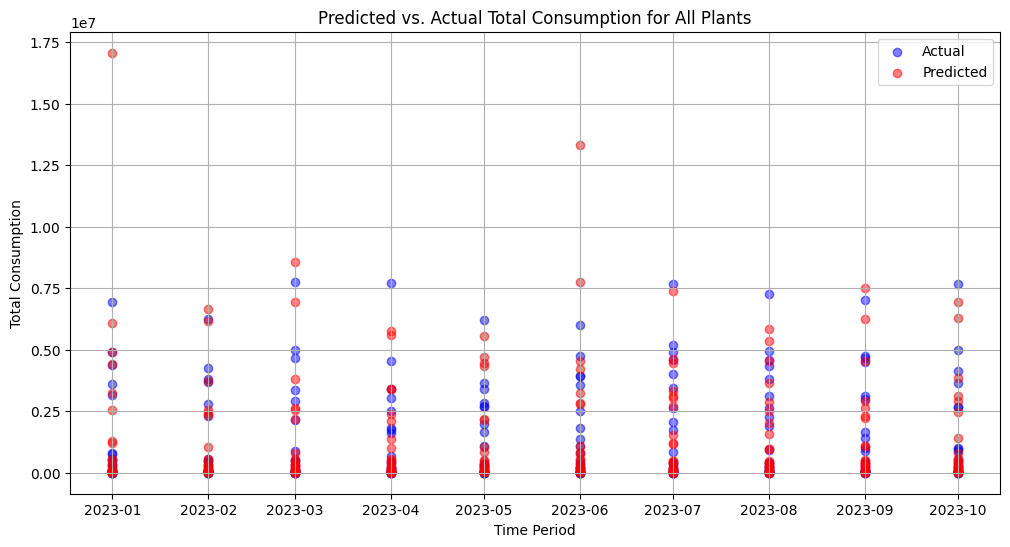

In [ ]:
# Group data by plant code
grouped_data = data.groupby('plantCode')

# Lists to store actual and predicted total consumption
actual_consumption_all = []
predicted_consumption_all = []
periods_all = []  # List to store periods for each data point

# Iterate over groups (plants)
for plant_code, plant_data in grouped_data:
    # Check if there is sufficient data for training and testing
    if len(plant_data) < 2:
        print(f"Not enough data for plant {plant_code}. Skipping...")
        continue
    
    # Exclude negative consumption values
    plant_data = plant_data[plant_data['total-consumption'] >= 0]
    
    # Extract features and target variable
    X = plant_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
    y = plant_data['total-consumption']
    
    # Extract time periods
    periods = plant_data['period']
    
    # Define the time periods for training and testing
    start_train = '2020-01-01'
    end_train = '2022-12-31'
    start_test = '2023-01-01'
    end_test = '2023-12-31'
    
    # Filter the data for training and testing
    train_data = plant_data[(plant_data['period'] >= start_train) & (plant_data['period'] <= end_train)]
    test_data = plant_data[(plant_data['period'] >= start_test) & (plant_data['period'] <= end_test)]
    
    # Check if there is sufficient data for training and testing
    if len(train_data) < 2 or len(test_data) < 2:
        print(f"Not enough data for plant {plant_code}. Skipping...")
        continue
    
    # Extract features and target variable for training
    X_train = train_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
    y_train = train_data['total-consumption']
    
    # Extract features and target variable for testing
    X_test = test_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
    y_test = test_data['total-consumption']
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Append actual and predicted total consumption
    actual_consumption_all.extend(y_test)
    predicted_consumption_all.extend(y_pred)
    periods_all.extend(periods[test_data.index])  # Assigning periods for each data point

# Remove negative values from the combined data
actual_consumption_all = np.array(actual_consumption_all)
predicted_consumption_all = np.array(predicted_consumption_all)
periods_all = np.array(periods_all)
mask = (actual_consumption_all >= 0) & (predicted_consumption_all >= 0)
actual_consumption_all = actual_consumption_all[mask]
predicted_consumption_all = predicted_consumption_all[mask]
periods_all = periods_all[mask]

# Evaluate the model for all plants combined
mse_all = mean_squared_error(actual_consumption_all, predicted_consumption_all)
r2_all = r2_score(actual_consumption_all, predicted_consumption_all)

print('Overall evaluation:')
print(f'Mean Squared Error: {mse_all}')
print(f'R-squared: {r2_all}')

# Plotting the predicted vs. actual total consumption for all plants
plt.figure(figsize=(12, 6))
plt.scatter(periods_all, actual_consumption_all, label='Actual', color='blue', alpha=0.5)
plt.scatter(periods_all, predicted_consumption_all, label='Predicted', color='red', alpha=0.5)
plt.title('Predicted vs. Actual Total Consumption for All Plants')
plt.xlabel('Time Period')
plt.ylabel('Total Consumption')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Group data by plant code
grouped_data = data.groupby('plantCode')

# Lists to store actual and predicted total consumption
actual_consumption_all = []
predicted_consumption_all = []
plant_colors = []  # List to store colors for each plant

# Iterate over groups (plants)
for plant_code, plant_data in grouped_data:
    # Check if there is sufficient data for training and testing
    if len(plant_data) < 2:
        print(f"Not enough data for plant {plant_code}. Skipping...")
        continue
    
    # Exclude negative consumption values
    plant_data = plant_data[plant_data['total-consumption'] >= 0]
    
    # Extract features and target variable
    X = plant_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
    y = plant_data['total-consumption']
    
    # Define the time periods for training and testing
    start_train = '2020-01-01'
    end_train = '2022-12-31'
    start_test = '2023-01-01'
    end_test = '2023-12-31'
    
    # Filter the data for training and testing
    train_data = plant_data[(plant_data['period'] >= start_train) & (plant_data['period'] <= end_train)]
    test_data = plant_data[(plant_data['period'] >= start_test) & (plant_data['period'] <= end_test)]
    
    # Check if there is sufficient data for training and testing
    if len(train_data) < 2 or len(test_data) < 2:
        print(f"Not enough data for plant {plant_code}. Skipping...")
        continue
    
    # Extract features and target variable for training
    X_train = train_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
    y_train = train_data['total-consumption']
    
    # Extract features and target variable for testing
    X_test = test_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
    y_test = test_data['total-consumption']
    
    # Define the degree of polynomial features
    degree = 2  # Change this value as needed
    
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Fit the model on the training data
    model.fit(X_train_poly, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_poly)
    
    # Append actual and predicted total consumption
    actual_consumption_all.extend(y_test)
    predicted_consumption_all.extend(y_pred)
    plant_colors.extend([plant_code] * len(y_pred))  # Assigning a color for each plant

# Remove negative values from the combined data
actual_consumption_all = np.array(actual_consumption_all)
predicted_consumption_all = np.array(predicted_consumption_all)
plant_colors = np.array(plant_colors)
mask = (actual_consumption_all >= 0) & (predicted_consumption_all >= 0)
actual_consumption_all = actual_consumption_all[mask]
predicted_consumption_all = predicted_consumption_all[mask]
plant_colors = plant_colors[mask]

# Evaluate the model for all plants combined
mse_all = mean_squared_error(actual_consumption_all, predicted_consumption_all)
r2_all = r2_score(actual_consumption_all, predicted_consumption_all)

print('Overall evaluation:')
print(f'Mean Squared Error: {mse_all}')
print(f'R-squared: {r2_all}')

# Plotting the predicted vs. actual total consumption for all plants
plt.figure(figsize=(12, 6))
plt.scatter(actual_consumption_all, predicted_consumption_all, c=plant_colors, cmap='viridis', alpha=0.5)
plt.plot([min(actual_consumption_all), max(actual_consumption_all)], [min(actual_consumption_all), max(actual_consumption_all)], 'k--', lw=2)  # Plotting the diagonal line
plt.title('Predicted vs. Actual Total Consumption for All Plants')
plt.xlabel('Actual Total Consumption')
plt.ylabel('Predicted Total Consumption')
plt.grid(True)
plt.colorbar(label='Plant Code')
plt.show()

Mean Squared Error (Polynomial): 4100904779028.716
R-squared (Polynomial): -0.17755561809613063


Clearly, linear and polynomial regression are not appropriate for capturing the underlying patterns in this data, given there is a periodic component to it, and that the R squared values are very low

In [16]:
X = data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
y = data['total-consumption']

# Define the time periods for training and testing
start_train = '2020-01-01'
end_train = '2022-12-31'
start_test = '2023-01-01'
end_test = '2023-12-31'

# Filter the data for training and testing
train_data = data[(data['period'] >= start_train) & (data['period'] <= end_train)]
test_data = data[(data['period'] >= start_test) & (data['period'] <= end_test)]

# Extract features and target variable for training
X_train = train_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
y_train = train_data['total-consumption']

# Extract features and target variable for testing
X_test = test_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
y_test = test_data['total-consumption']

# Create a Random Forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust parameters as needed

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 3370064140621.7744
R-squared: 0.032301851428652606


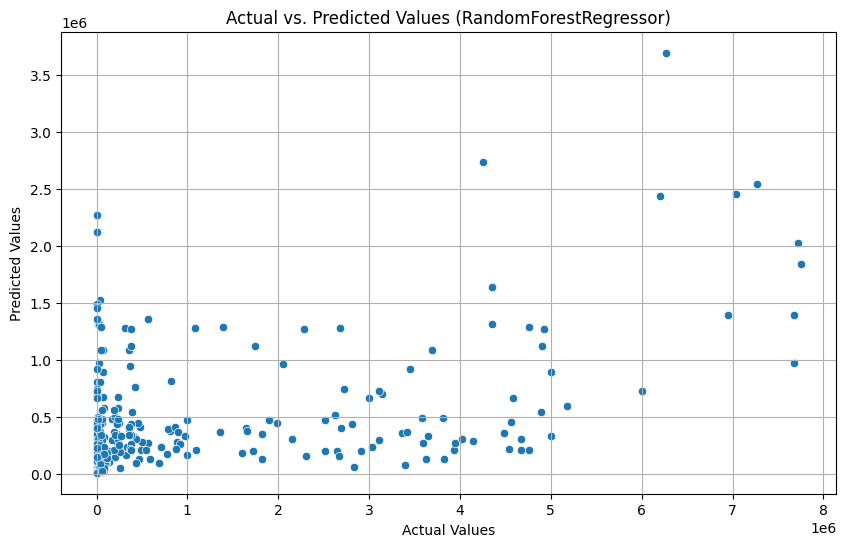

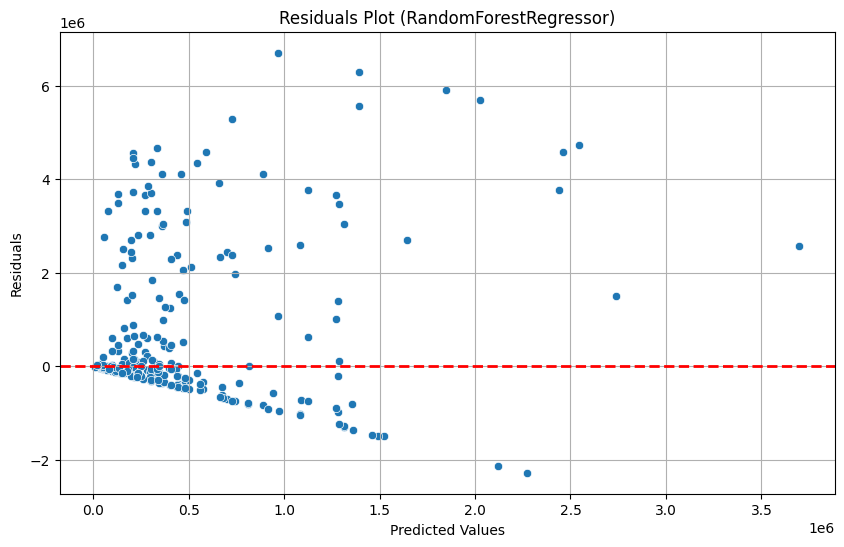

In [17]:
# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs. Predicted Values (RandomForestRegressor)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Visualize the residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.title('Residuals Plot (RandomForestRegressor)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

Clearly, there is some trend to the residuals. So an important feature may be missing from the data - or a more advanced/nonlinear model needs to be used. (support vector machine/neural network)

PCA, feature importance, ARIMA

In [9]:

# Preload data for all plants
start_train = '2020-01-01'
end_train = '2022-12-31'
start_test = '2023-01-01'
end_test = '2023-12-31'

train_data = data[(data['period'] >= start_train) & (data['period'] <= end_train)]
test_data = data[(data['period'] >= start_test) & (data['period'] <= end_test)]

# Extract features and target variable for training
X_train_all = train_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
y_train_all = train_data['total-consumption']

# Extract features and target variable for testing
X_test_all = test_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
y_test_all = test_data['total-consumption']

# Create a linear regression model
model_all = LinearRegression()

# Fit the model on the training data for all plants
model_all.fit(X_train_all, y_train_all)

# Make predictions on the test set for all plants
y_pred_all = model_all.predict(X_test_all)

# Function to generate the plot based on selected plant
def plot_consumption(plant_code):
    # Aggregate if no plant selected
    if plant_code == 'Aggregate':
        y_test = y_test_all
        y_pred = y_pred_all
    else:
        # Filter data for the selected plant
        plant_data = data[data['plantCode'] == plant_code]

        # Extract features and target variable for testing
        X_test = plant_data[['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP']]
        y_test = plant_data['total-consumption']

        # Make predictions for the selected plant
        y_pred = model_all.predict(X_test)

    # Plotting the predicted vs. actual total consumption
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.title('Predicted vs. Actual Total Consumption')
    plt.xlabel('Actual Total Consumption')
    plt.ylabel('Predicted Total Consumption')
    plt.grid(True)
    plt.show()

# Get unique plant codes
plant_codes = data['plantCode'].unique().tolist()
plant_codes.append('Aggregate')  # Add 'Aggregate' option for aggregate plot

# Create interactive dropdown for plant selection
interact(plot_consumption, plant_code=widgets.Dropdown(options=plant_codes, description='Plant Code'))